In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
import warnings
import sys
import seawater as sw
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle
import matplotlib.gridspec as gridspec


from dask.diagnostics import ProgressBar

import scipy.integrate as integ
warnings.filterwarnings("ignore")

In [2]:
def ogive(deltaf,G):
    '''
    ogive(deltaf,G): use very simple integration to calculate the ogive 
    from a spectrum G with data sampled at frequency deltaf.
    2017-01-10T09:40:31 going back to a single frequency for Os and Gs
    '''
    M1 = len(G)
    Og = np.zeros(M1,float)
    Og[0:M1] = np.cumsum(np.flipud(G[0:M1]))
    Og *= deltaf
    Og = np.flipud(Og)
    return Og




In [23]:



plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']



In [4]:
def spec_ogive(spec,kr):
    
    Ogive_Kr=np.array(kr)
    # Middle Value Wavenumber position for plot
    Ogive_Krx=(Ogive_Kr[:-1]+Ogive_Kr[1:])/2
    # dK=np.diff(Ogive_Kr)[0]
    
    #Flipped Integration in wavenumber and then flipped again
    Ogive_inv=integ.cumtrapz(y=spec[::-1],x=Ogive_Kr[::-1]);
    Ogive_Spec=-Ogive_inv[::-1];


    return Ogive_Krx,Ogive_Spec

def ogive(deltaf,G):
   '''
   ogive(deltaf,G): use very simple integration to calculate the ogive 
   from a spectrum G with data sampled at frequency deltaf.
   2017-01-10T09:40:31 going back to a single frequency for Os and Gs
   '''
# --------------------------------------------------------------------
# 2016-10-08T09:47:12 re-created with numpy
# --------------------------------------------------------------------
   M1 = len(G)
   Og = np.zeros(M1,float)
   Og[0:M1] = np.cumsum(np.flipud(G[0:M1]))
   Og *= deltaf
   Og = np.flipud(Og)
   return Og



In [5]:

path='/data/pacific/lrenault/SASI/CROCO/FULL/'
listm=glob(path+'surf*.nc');listm.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varf=xr.open_mfdataset(listm[1:],data_vars='minimal')

path='/data/pacific/lrenault/SASI/CROCO/SMTH/'
listt=glob(path+'surf*SASI_6h_his_20*_*.nc');listt.sort()
listt.append('/data/pacific/lrenault/SASI/CROCO/SMTH/surf_SASI_6h_his_2012-07.nc')
#vart=xr.open_dataset(listt[xmon])
vart=xr.open_mfdataset(listt[1:],data_vars='minimal')

In [6]:
dxx=0.5
dyy=dxx

In [7]:
import datetime

# t_ind=pd.DatetimeIndex(varf.time_counter.compute())
t_ind=varf.time_counter.groupby("time_counter.dayofyear").mean()
t_ind_h=varf.time_counter


mon_ind=t_ind.dt.month
mes=np.array([12,1,2,3,4,5,6,7])
mes_str=['Dec/11','Jan/12','Feb/12','Mar/12','Apr/12','May/12','Jun/12','Jul/12']

In [8]:
chunks_new={'time_counter':120}

In [9]:
%%time
uf=varf.u#.groupby("time_counter.dayofyear").mean()
uf=uf.chunk(chunks=chunks_new);
# u_f=(uf[:,1:,:]+uf[:,:-1,:])/2
uf=uf.compute();

ut=vart.u#.groupby("time_counter.dayofyear").mean()
ut=ut.chunk(chunks=chunks_new);
# ut=(ut[:,1:,:]+ut[:,:-1,:])/2
ut=ut.compute();

vf=varf.v#.groupby("time_counter.dayofyear").mean()
vf=vf.chunk(chunks=chunks_new);
# vf=(vf[:,:,1:]+vf[:,:,:-1])/2
vf=vf.compute();

vt=vart.v#.groupby("time_counter.dayofyear").mean()
vt=vt.chunk(chunks=chunks_new);
# vt=(vt[:,:,1:]+vt[:,:,:-1])/2
vt=vt.compute();



CPU times: user 10.9 s, sys: 13.4 s, total: 24.2 s
Wall time: 1min 58s


In [10]:
uf,vf,_=romspickle.uvw2rho_3d(uf,vf,uf)
uf,vf=uf[:,120:-120,120:800],vf[:,120:-120,120:800]

ut,vt,_=romspickle.uvw2rho_3d(ut,vt,ut)
ut,vt=ut[:,120:-120,120:800],vt[:,120:-120,120:800]

In [11]:
nf=2

In [12]:
u2d_full=xrft.power_spectrum(uf,dim=(['x_u','y_u']))
u2d_smth=xrft.power_spectrum(ut,dim=(['x_u','y_u']))
v2d_full=xrft.power_spectrum(vf,dim=(['x_v','y_v']))
v2d_smth=xrft.power_spectrum(vt,dim=(['x_v','y_v']))

In [13]:
v2d_full=v2d_full.rename({'freq_y_v':'freq_y_u','freq_x_v':'freq_x_u'})
v2d_smth=v2d_smth.rename({'freq_y_v':'freq_y_u','freq_x_v':'freq_x_u'})

In [99]:
# u2d_full=xrft.power_spectrum(uf[0])
# u2d_smth=xrft.power_spectrum(ut[0])

# v2d_full=xrft.power_spectrum(vf[0])
# v2d_smth=xrft.power_spectrum(vt[0])
# v2d_full=v2d_full.rename({'freq_y_v':'freq_y_u','freq_x_v':'freq_x_u'})
# v2d_smth=v2d_smth.rename({'freq_y_v':'freq_y_u','freq_x_v':'freq_x_u'})

### Divergence

In [12]:
# div_full_2dspec=(u2d_full)*u2d_full.freq_x_u**2 + (v2d_full)*v2d_full.freq_y_u**2
# div_smth_2dspec=(u2d_smth)*u2d_smth.freq_x_u**2 + (v2d_smth)*v2d_smth.freq_y_u**2

# div_full_ispec=xrft.isotropize(div_full_2dspec,fftdim=['freq_y_u','freq_x_u'],nfactor=nf)
# div_smth_ispec=xrft.isotropize(div_smth_2dspec,fftdim=['freq_y_u','freq_x_u'],nfactor=nf)

In [13]:
# plt.figure(figsize=(9,7))


# plt.plot(div_full_ispec.freq_r/dxx,div_full_ispec.mean(axis=0)/dxx*1e3,label='FULL',linewidth=2,color='cornflowerblue')
# plt.plot(div_smth_ispec.freq_r/dxx,div_smth_ispec.mean(axis=0)/dxx*1e3,label='SMTH',linewidth=2,color='tomato')
# # plt.plot([1/50,1/50],[1000,0],'k--')

# plt.legend()

# plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')
# plt.ylabel(r'Spectral Density [m$^{1}$s$^{-2}$]',fontweight='bold')

# plt.title(r'$k_x^{2}$$\hat{u}^2$ + $k_y^{2}$$\hat{v}^2$',fontsize=25,fontweight='bold')
# plt.yscale('log')
# plt.xscale('log')

# plt.ylim(2e-3,1.2e-2)
# plt.xlim(1e-2,1)
# # plt.grid()

# # plt.tight_layout()

### Vorticity

In [118]:
# vort_full_2dspec=(v2d_full)*v2d_full.freq_x_u**2# - (u2d_full)*u2d_full.freq_y_u**2
# vort_smth_2dspec=(v2d_smth)*v2d_smth.freq_x_u**2# - (u2d_smth)*u2d_smth.freq_y_u**2

# vort_full_ispec=xrft.isotropize(vort_full_2dspec,fftdim=['freq_y_u','freq_x_u'],nfactor=nf)
# vort_smth_ispec=xrft.isotropize(vort_smth_2dspec,fftdim=['freq_y_u','freq_x_u'],nfactor=nf)



# vort_full_a_2dspec=(v2d_full)*v2d_full.freq_x_u**2# - (u2d_full)*u2d_full.freq_y_u**2
# vort_smth_a_2dspec=(v2d_smth)*v2d_smth.freq_x_u**2# - (u2d_smth)*u2d_smth.freq_y_u**2


# vort_full_b_2dspec= (u2d_full)*u2d_full.freq_y_u**2
# vort_smth_b_2dspec= (u2d_smth)*u2d_smth.freq_y_u**2


# vort_full_ispec_a=xrft.isotropize(vort_full_a_2dspec,fftdim=['freq_y_u','freq_x_u'],nfactor=nf)
# vort_smth_ispec_a=xrft.isotropize(vort_smth_a_2dspec,fftdim=['freq_y_u','freq_x_u'],nfactor=nf)


# vort_full_ispec_b=xrft.isotropize(vort_full_b_2dspec,fftdim=['freq_y_u','freq_x_u'],nfactor=nf)
# vort_smth_ispec_b=xrft.isotropize(vort_smth_b_2dspec,fftdim=['freq_y_u','freq_x_u'],nfactor=nf)

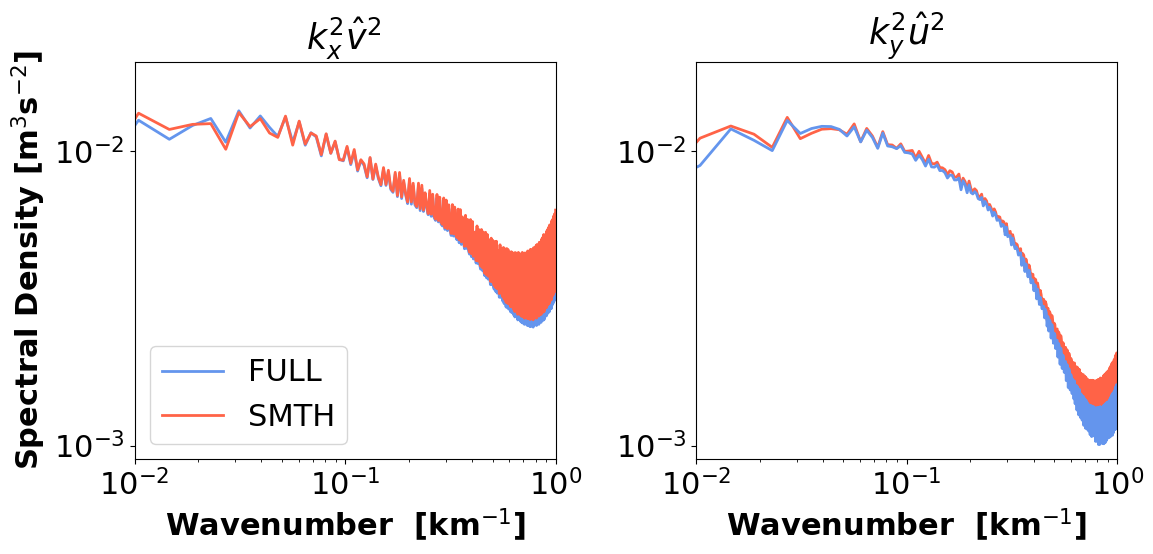

In [126]:
# plt.figure(figsize=(12,6))
# plt.subplot(1,2,1)

# plt.plot(vort_full_ispec_a.freq_r/dxx,vort_full_ispec_a.mean(axis=0)/dxx*1e3,label='FULL',linewidth=2,color='cornflowerblue')
# plt.plot(vort_smth_ispec_a.freq_r/dxx,vort_smth_ispec_a.mean(axis=0)/dxx*1e3,label='SMTH',linewidth=2,color='tomato')
# # plt.plot([1/50,1/50],[1000,0],'k--')

# plt.legend()

# plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')
# plt.ylabel(r'Spectral Density [m$^{3}$s$^{-2}$]',fontweight='bold')

# plt.title(r'$k_x^{2}$$\hat{v}^2$ ',fontsize=25,fontweight='bold')
# plt.yscale('symlog',linthresh=1e-6)
# plt.xscale('log')

# plt.ylim(0.9e-3,2e-2)

# plt.xlim(1e-2,1)
# # # plt.grid()

# plt.subplot(1,2,2)
# plt.plot(vort_smth_ispec_b.freq_r/dxx,vort_smth_ispec_b.mean(axis=0)/dxx*1e3,label='SMTH',linewidth=2,color='tomato')


# plt.plot(vort_full_ispec_b.freq_r/dxx,vort_full_ispec_b.mean(axis=0)/dxx*1e3,label='FULL',linewidth=2,color='cornflowerblue')
# # plt.plot([1/50,1/50],[1000,0],'k--')

# # plt.legend()

# plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')
# # plt.ylabel(r'Spectral Density [m$^{3}$s$^{-2}$]',fontweight='bold')

# plt.title(r'$k_y^{2}$$\hat{u}^2$',fontsize=25,fontweight='bold')
# plt.yscale('symlog',linthresh=1e-6)
# plt.xscale('log')

# plt.ylim(0.9e-3,2e-2)
# plt.xlim(1e-2,1)
# # # plt.grid()

# plt.tight_layout()




## Second Method

In [12]:
zeta_full=  uf*0 + (np.gradient(vf,axis=1)/dxx - np.gradient(uf,axis=2)/dxx)
zeta_smth=  ut*0 + (np.gradient(vt,axis=1)/dxx - np.gradient(ut,axis=2)/dxx)


In [13]:
sigma_full=  uf*0 + (np.gradient(uf,axis=2)/dxx + np.gradient(vf,axis=1)/dxx)
sigma_smth=  ut*0 + (np.gradient(ut,axis=2)/dxx + np.gradient(vt,axis=1)/dxx)

In [14]:
nf=2
wdws='hann' #'flattop','hann'
wdw_cor=True
scl='density'

In [15]:
with ProgressBar():
    zeta_full_ispec=xrft.isotropic_power_spectrum(zeta_full,dim=['x_u','y_u'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)
    zeta_smth_ispec=xrft.isotropic_power_spectrum(zeta_smth,dim=['x_u','y_u'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)
    sigma_full_ispec=xrft.isotropic_power_spectrum(sigma_full,dim=['x_u','y_u'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)
    sigma_smth_ispec=xrft.isotropic_power_spectrum(sigma_smth,dim=['x_u','y_u'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor)

In [16]:
E_full_2dspec=(u2d_full) + (v2d_full)
E_smth_2dspec=(u2d_smth) + (v2d_smth)

E_full_ispec=xrft.isotropize(E_full_2dspec,fftdim=['freq_y_u','freq_x_u'],nfactor=nf)
E_smth_ispec=xrft.isotropize(E_smth_2dspec,fftdim=['freq_y_u','freq_x_u'],nfactor=nf)

NameError: name 'u2d_full' is not defined

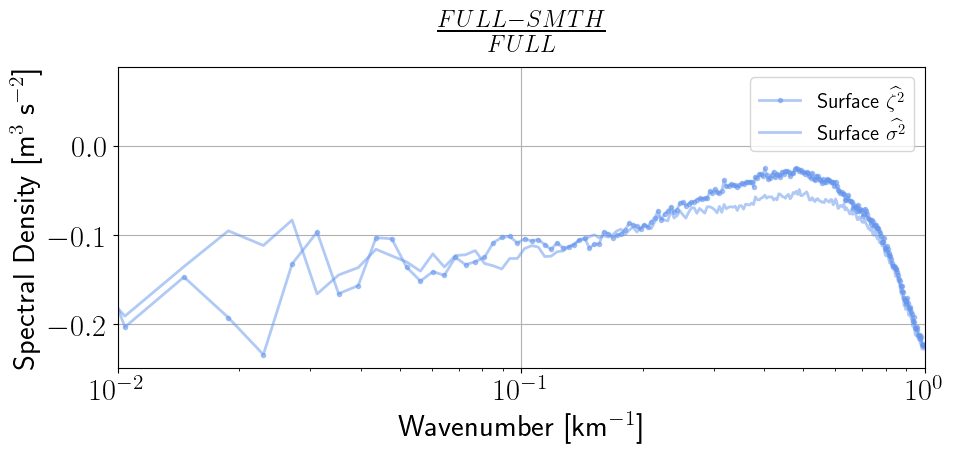

In [25]:
plt.figure(figsize=(10,5))



plt.plot((zeta_full_ispec.freq_r/dxx),
         ((zeta_full_ispec-zeta_smth_ispec)/zeta_full_ispec).mean(axis=0),label=r'Surface $\widehat{\zeta^2}$',linewidth=2,marker='.',color='cornflowerblue',alpha=0.5)
plt.plot((sigma_full_ispec.freq_r/dxx),
         ((sigma_full_ispec-sigma_smth_ispec)/sigma_full_ispec).mean(axis=0),label=r'Surface $\widehat{\sigma^2}$',linewidth=2,color='cornflowerblue',alpha=0.5)



plt.legend(fontsize=15)

plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')
plt.ylabel(r'Spectral Density [m$^{3}$ s$^{-2}$]',fontweight='bold')

plt.title(r'$\frac{FULL-SMTH}{FULL}$ ',fontsize=25,fontweight='bold',pad=20)
# plt.yscale('log')
plt.xscale('log')
# plt.ylim(1,1.5)
plt.xlim(1e-2,1)
plt.grid()

plt.tight_layout()

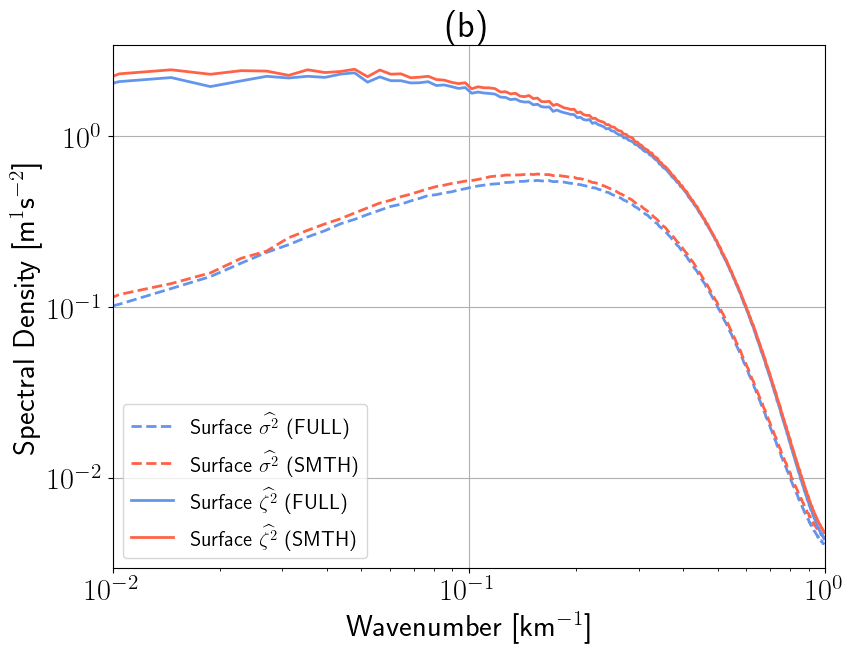

In [32]:

# plt.rc('text', usetex=True)


plt.figure(figsize=(9,7))

plt.plot(sigma_full_ispec.freq_r/dxx,sigma_full_ispec.mean(axis=0)/dxx*1e3,label='Surface $\widehat{\sigma^2}$ (FULL)',linestyle='--',linewidth=2,color='cornflowerblue')
plt.plot(sigma_smth_ispec.freq_r/dxx,sigma_smth_ispec.mean(axis=0)/dxx*1e3,label='Surface $\widehat{\sigma^2}$ (SMTH)',linestyle='--',linewidth=2,color='tomato')

plt.plot(zeta_full_ispec.freq_r/dxx,zeta_full_ispec.mean(axis=0)/dxx*1e3,label='Surface $\widehat{\zeta^2}$ (FULL)',linewidth=2,color='cornflowerblue')
plt.plot(zeta_smth_ispec.freq_r/dxx,zeta_smth_ispec.mean(axis=0)/dxx*1e3,label='Surface $\widehat{\zeta^2}$ (SMTH)',linewidth=2,color='tomato')
# plt.plot([1/50,1/50],[1000,0],'k--')

# plt.plot(E_full_ispec.freq_r/dxx,(E_full_ispec.mean(axis=0)/dxx*1e3)*E_full_ispec.mean(axis=0).freq_r**2*1e3,label='FULL',marker='o',linewidth=2,color='cornflowerblue')
# plt.plot(E_smth_ispec.freq_r/dxx,E_smth_ispec.mean(axis=0)*E_smth_ispec.mean(axis=0).freq_r**2*1e3,label='SMTH',marker='o',linewidth=2,color='tomato')
# plt.text(1.23e-2,1.2,r'$\hat{\zeta}^2(k)$',color='grey')
# plt.text(1.23e-2,0.7e-1,r'$\hat{\sigma}^2(k)$',color='grey')



plt.legend(fontsize=15)

plt.xlabel(r'Wavenumber  [km$^{-1}$]')
plt.ylabel(r'Spectral Density [m$^{1}$s$^{-2}$]')

# plt.title(r'$\hat{\zeta}^2$ ',fontsize=25,fontweight='bold')
plt.yscale('symlog',linthresh=1e-6)
plt.xscale('log')

# plt.ylim(0.9e-3,2e-2)

plt.xlim(1e-2,1)
plt.grid()
plt.title('(b)')
plt.tight_layout()
# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/total_avg/div_vort_spectral_both.png')





In [103]:


# plt.figure(figsize=(10,5))

# plt.plot(sigma_full_ispec.freq_r/dxx,sigma_full_ispec.mean(axis=0)/dxx*1e3,label='FULL',linewidth=2,color='cornflowerblue')
# plt.plot(sigma_smth_ispec.freq_r/dxx,sigma_smth_ispec.mean(axis=0)/dxx*1e3,label='SMTH',linewidth=2,color='tomato')

# # plt.text(1.23e-2,0.8e-1,r'$\sigma$',color='grey')

# plt.title(r'$\hat{\sigma}^2(k)$')


# plt.legend()

# plt.xlabel(r'Wavenumber  [km$^{-1}$]')
# plt.ylabel(r'Spectral Density [m$^{1}$s$^{-2}$]')

# # plt.title(r'$\hat{\zeta}^2$ ',fontsize=25,fontweight='bold')
# plt.yscale('symlog',linthresh=1e-6)
# plt.xscale('log')

# # plt.ylim(0.9e-3,2e-2)

# plt.xlim(1e-2,1)
# plt.grid()
# plt.tight_layout()
# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/total_avg/div_spectral.png')




In [102]:
# plt.figure(figsize=(10,6))

# plt.plot(zeta_full_ispec.freq_r/dxx,zeta_full_ispec.mean(axis=0)/dxx*1e3,linewidth=2,color='cornflowerblue')
# plt.plot(zeta_smth_ispec.freq_r/dxx,zeta_smth_ispec.mean(axis=0)/dxx*1e3,linewidth=2,color='tomato')

# plt.title(r'$\hat{\zeta}^2(k)$')


# plt.xlabel(r'Wavenumber  [km$^{-1}$]')
# plt.ylabel(r'Spectral Density [m$^{1}$s$^{-2}$]')

# # plt.title(r'$\hat{\zeta}^2$ ',fontsize=25,fontweight='bold')
# plt.yscale('symlog',linthresh=1e-6)
# plt.xscale('log')

# # plt.ylim(0.9e-3,2e-2)

# plt.xlim(1e-2,1)
# plt.grid()
# plt.tight_layout()
# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/total_avg/vort_spectral.png')





# Ogives

In [43]:
KAf=ogive(zeta_full_ispec.freq_r/dxx*1e3,zeta_full_ispec.mean('time_counter')/dxx*1e3) #in metersss
Kxa=zeta_full_ispec.freq_r/dxx #in Kilometers
KAt=ogive(zeta_smth_ispec.freq_r/dxx*1e3,zeta_smth_ispec.mean('time_counter')/dxx*1e3) #in metersss



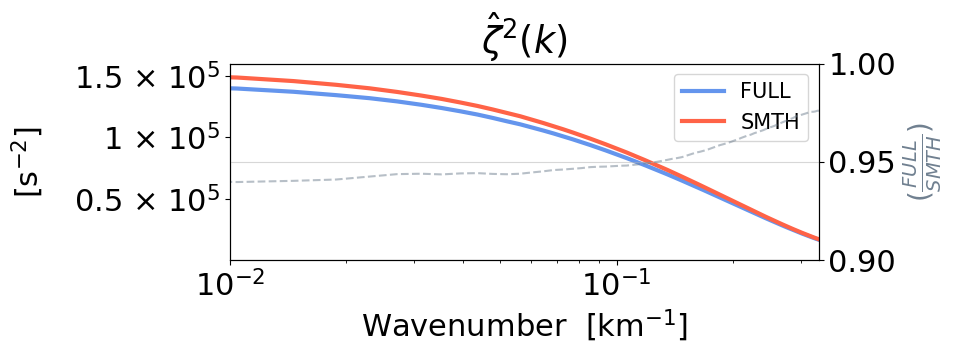

In [114]:
fig = plt.figure(figsize=(10,4))

ax1=plt.subplot(1,1,1)
ax1.plot(Kxa,KAf,label='FULL',linewidth=3,color='cornflowerblue')
ax1.plot(Kxa,KAt,label='SMTH',linewidth=3,color='tomato')
# ax.set_title('PE',fontsize=25,fontweight='bold')
ax1.set_xscale('log')
ax1.set_title(r'$\hat{\zeta}^2(k)$')





ax1.set_xlabel(r'Wavenumber  [km$^{-1}$]')
ax1.set_ylabel(r'[s$^{-2}$]',labelpad=20)
ax1.set_xlim(1e-2,1/3)
ax1.set_ylim(-1e-1,1.6e5)
ax1.set_yticks([0.5e5,1e5,1.5e5])
ax1.set_yticklabels([r'0.5 $\times$ 10$^{5}$',r'1 $\times$ 10$^{5}$',r'1.5 $\times$ 10$^{5}$'])



ax1.legend(fontsize=15)

ax12=ax1.twinx()
ax12.plot((Kxa),((KAf)/(KAt)),alpha=0.5,linestyle='dashed',color='slategrey')
ax12.set_ylabel(r'($\frac{FULL}{SMTH}$)',fontsize=20,color='slategrey')
ax12.set_xscale('log')
# ax12.set_yticks([0.80,0.90,1])
ax12.set_ylim(0.9,1)
ax12.grid(alpha=0.5)
plt.tight_layout()

plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/total_avg/vort_spectral_ogive.png')




In [69]:
KBf=ogive(sigma_full_ispec.freq_r/dxx*1e3,sigma_full_ispec.mean('time_counter')/dxx*1e3) #in metersss
Kxb=sigma_full_ispec.freq_r/dxx #in Kilometers
KBt=ogive(sigma_smth_ispec.freq_r/dxx*1e3,sigma_smth_ispec.mean('time_counter')/dxx*1e3) #in metersss




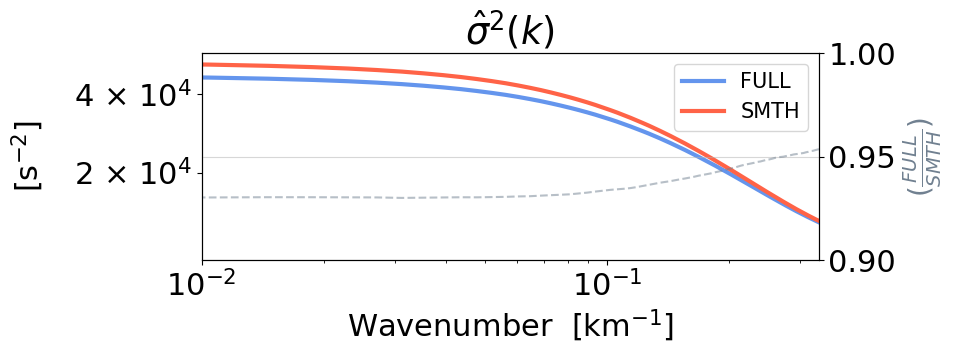

In [115]:
fig = plt.figure(figsize=(10,4))

ax1=plt.subplot(1,1,1)
ax1.plot(Kxb,KBf,label='FULL',linewidth=3,color='cornflowerblue')
ax1.plot(Kxb,KBt,label='SMTH',linewidth=3,color='tomato')
# ax.set_title('PE',fontsize=25,fontweight='bold')
ax1.set_xscale('log')
ax1.set_title(r'$\hat{\sigma}^2(k)$')




ax1.set_xlabel(r'Wavenumber  [km$^{-1}$]')
ax1.set_ylabel(r'[s$^{-2}$]',labelpad=20)
ax1.set_xlim(1e-2,1/3)
# ax1.set_ylim(-1e-1,5e4)
ax1.set_yticks([2e4,4e4])
ax1.set_yticklabels([r'2 $\times$ 10$^{4}$',r'4 $\times$ 10$^{4}$'])



ax1.legend(fontsize=15)


ax12=ax1.twinx()
ax12.plot((Kxb),((KBf)/(KBt)),alpha=0.5,linestyle='dashed',color='slategrey')
ax12.set_ylabel(r'($\frac{FULL}{SMTH}$)',fontsize=20,color='slategrey')
ax12.set_xscale('log')
# ax12.set_yticks([0.80,0.90,1])
ax12.set_ylim(0.9,1)
ax12.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/total_avg/div_spectral_ogive.png')

